In [2]:
import os
import re
import pickle

import numpy as np
import pandas as pd
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Flatten
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.metrics import Precision, Recall, AUC, F1Score
from tensorflow.keras.optimizers import Adamax, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, roc_auc_score, f1_score


In [ ]:
df_images = pd.read_csv('df_images.csv')
df_masks = pd.read_csv('df_masks.csv')

In [ ]:

def preproc_img(df_images, df_masks, n_img, normalize, files_path, resolution, with_masks):
    np.random.seed(42)

    # Gestion des erreurs
    if resolution[2] != 1 and resolution[2] != 3:
        return print("Le nombre de canaux doit être de 1 (en nuances de gris) ou de 3 (en couleur)")

    if resolution[0] != resolution[1]:
        return print("La largeur de l'image doit être la même que sa hauteur.")

    df_images_selected_list = []
    for label, group in df_images.groupby('LABEL'):
        n_samples = min(len(group), n_img)
        df_images_selected_list.append(group.sample(n=n_samples, replace=False))
    df_images_selected = pd.concat(df_images_selected_list)

    # Initialiser une liste pour stocker les images prétraitées
    images = []

    # Sélectionner le nombre d'image à utiliser par classe
    df_masks_selected = df_masks[df_masks['FILE_NAME'].isin(df_images_selected['FILE_NAME'])] if with_masks else None

    for i in range(len(df_images_selected)):
        img_path = df_images_selected[files_path].iloc[i]
        mask_path = df_masks_selected[files_path].iloc[i] if with_masks else None

        # Charger l'image avec PIL
        img = Image.open(img_path)
        img = img.convert("L")  # Convertir en niveaux de gris

        if resolution[2] == 3:
            img = img.convert("RGB")  # Convertir en mode RGB

        img_resized = img.resize((resolution[0], resolution[1]))

        # Normalisation des valeurs des pixels
        if normalize:
            if resolution[2] == 1:  # Image en nuances de gris
                mean_gray = np.mean([0.485, 0.456, 0.406])
                std_gray = np.mean([0.229, 0.224, 0.225])
                img_normalized = (img_resized / 255.0 - mean_gray) / std_gray
            elif resolution[2] == 3:  # Image en couleur
                img_normalized = np.array(img_resized) / 255.0
                img_normalized -= np.array([0.485, 0.456, 0.406])
                img_normalized /= np.array([0.229, 0.224, 0.225])
        else:
            img_normalized = img_resized

        # Ajouter l'image à la liste
        images.append(img_normalized)

    # Reshaper pour ajouter la dimension du canal
    data = np.array(images).reshape(-1, resolution[0], resolution[1], resolution[2])
    target = df_images_selected['LABEL']

    return data, target

# Utilisation de la fonction
data, target = preproc_img(df_images, df_masks, n_img=1345, normalize=True, files_path='PATH_NOMASK', resolution=[224, 224, 3], with_masks=False)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

label_encoder = LabelEncoder()

# Encoder les labels textuels en entiers
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Appliquer l'encodage one-hot
y_train = to_categorical(y_train_encoded)
y_test = to_categorical(y_test_encoded)

# Vérifier les dimensions
print("Labels de l'ensemble d'entrainement après encodage one-hot :", y_train.shape)
print("Labels de l'ensemble de test après encodage one-hot :", y_test.shape)


In [ ]:
# Construction du modèle
densenet = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Dégel de plus de couches pour l'ajustement fin
for layer in densenet.layers[-32:]:
    layer.trainable = True

# Ajout de la tête de classification
x = densenet.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=densenet.input, outputs=predictions)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=categorical_crossentropy,
    metrics=[Precision(), Recall(), AUC(), F1Score()]
)

early_stopper = EarlyStopping(
    monitor='val_loss',    # Surveiller la perte de validation
    min_delta=0.001,       # Seuil pour juger qu'une amélioration est significative
    patience=5,            # Nombre d'époques sans amélioration après lesquelles l'entraînement sera arrêté
    verbose=1,             # Afficher les messages d'arrêt
    mode='auto',
    restore_best_weights=True 
)

# Entraînement du modèle avec les générateurs
history = model.fit(
    x = X_train,  # Données d'entraînement
    y = y_train,  # Étiquettes d'entraînement
    validation_data = (X_test, y_test),  # Données et étiquettes de validation
    batch_size = 32,
    shuffle = True, # Mélange les images à chaque epoch
    epochs = 20,  # Nombre d'époques d'entraînement
    verbose = 1,
    callbacks = [early_stopper]
)
 

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Obtenir la classe avec la probabilité la plus élevée, si softmax est utilisé
y_test_classes = np.argmax(y_test, axis=1)
class_labels = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
report = classification_report(y_test_classes, y_pred_classes, target_names=class_labels)
print("Rapport de Classification :\n", report)

In [ ]:
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# Exemple de matrice de confusion
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# Liste ordonnée des noms de classe
class_labels = ['COVID', 'Lung Opacity', 'Normal', 'Viral Pneumonia']

plt.figure(figsize=(5, 4))  # Spécifier la couleur du contour de la figure

# Tracer la carte thermique avec un contour noir
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels, annot_kws={"fontsize":8})

plt.title('Matrice de Confusion : DenseNet201 fine-tuned', fontsize = 10)
plt.xlabel('Labels prédits', fontsize = 9)
plt.ylabel('Vrais labels', fontsize = 9)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.yticks(rotation=0.5)
plt.xticks(rotation=1)

plt.show()

In [4]:
with open('/kaggle/working/history_DenseNet201_finetuned_0_95_final.pkl', 'rb') as fichier:
    # Charger les données à partir du fichier
    history = pickle.load(fichier)
    
print(history)

{'auc': [0.9589441418647766, 0.9946197271347046, 0.9986315965652466, 0.9996484518051147, 0.9998603463172913, 0.9993934631347656, 0.9996643662452698, 0.9995664954185486, 0.999770998954773, 0.9996048212051392, 0.9994460344314575, 0.9996955990791321, 0.9999416470527649, 0.9995721578598022, 0.9998140931129456, 0.9990821480751038, 0.9992627501487732, 0.9999131560325623, 0.9998182058334351, 0.9996521472930908], 'f1_score': [<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.8121731 , 0.7966339 , 0.7601475 , 0.92720646], dtype=float32)>, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.9586076 , 0.9266697 , 0.90826094, 0.98046505], dtype=float32)>, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.9805594 , 0.95777255, 0.94885844, 0.9897864 ], dtype=float32)>, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.9877358, 0.9801568, 0.9755422, 0.9925719], dtype=float32)>, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.9914772 , 0.9843317 , 0.98618776, 0.99814296], dtype=flo

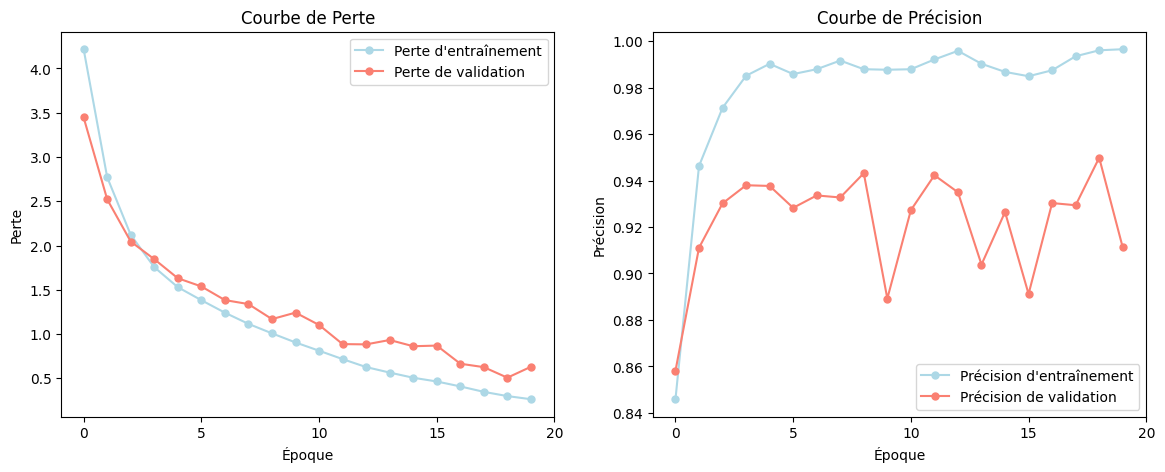

In [11]:

def plot_lc(history):

    plt.figure(figsize=(14, 5))
    
    # Tracer la courbe de perte
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], 
             color = 'lightblue',
             linestyle = '-',
             marker = 'o',
             markersize = 5,
             label = 'Perte d\'entraînement')
    plt.plot(history['val_loss'],
             color = 'salmon',
             linestyle = '-',
             marker = 'o',
             markersize = 5,
             label = 'Perte de validation')
    plt.title('Courbe de Perte')
    plt.xlabel('Époque')
    plt.ylabel('Perte')
    plt.xticks(range(0, 21, 5))
    plt.legend()
    plt.grid(False)
    
    # Tracer la courbe d'accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['precision'], 
             color = 'lightblue',
             linestyle = '-',
             marker = 'o',
             markersize = 5,
             label = "Précision d'entraînement")
    plt.plot(history['val_precision'],
             color = 'salmon',
             linestyle = '-',
             marker = 'o',
             markersize = 5,
             label = 'Précision de validation')
    plt.title('Courbe de Précision')
    plt.xlabel('Époque')
    plt.ylabel('Précision')
    plt.xticks(range(0, 21, 5))
    plt.legend()
    plt.grid(False)
   
    plt.show()
    
plot_lc(history)

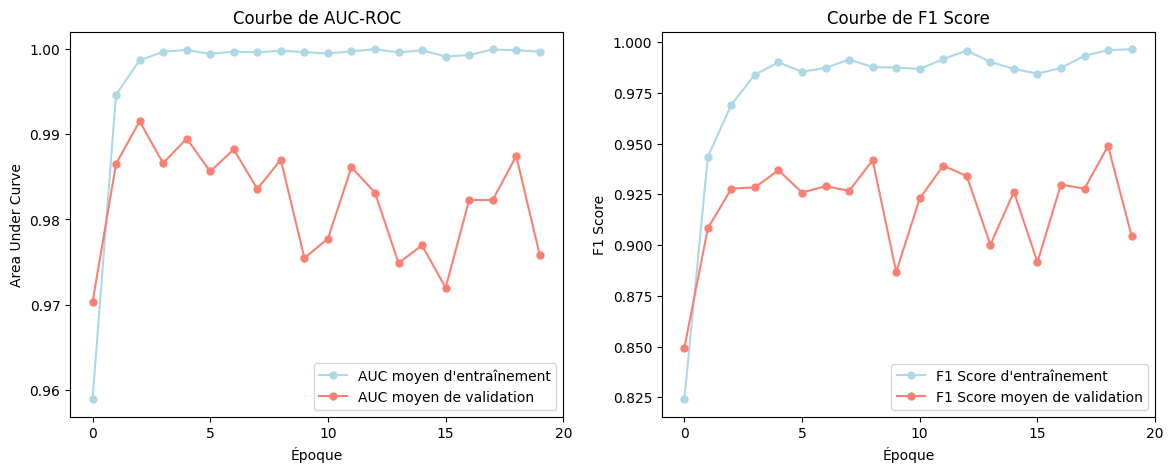

In [15]:
def plot_auc_f1(history):
    
    plt.figure(figsize=(14, 5))
    
    # Tracer la courbe AUC
    plt.subplot(1, 2, 1)
    plt.plot(history['auc'], 
             color = 'lightblue',
             linestyle = '-',
             marker = 'o',
             markersize = 5,
             label = "AUC moyen d'entraînement")
    plt.plot(history['val_auc'],
             color = 'salmon',
             linestyle = '-',
             marker = 'o',
             markersize = 5,
             label = 'AUC moyen de validation')
    plt.title('Courbe de AUC-ROC')
    plt.xlabel('Époque')
    plt.ylabel('Area Under Curve')
    plt.xticks(range(0, 21, 5))
    plt.legend()
    plt.grid(False)
    
    # Tracer la courbe F1 Score
    plt.subplot(1, 2, 2)
    plt.plot(np.mean(history['f1_score'], axis = 1), 
             color = 'lightblue',
             linestyle = '-',
             marker = 'o',
             markersize = 5,
             label = "F1 Score d'entraînement")
    plt.plot(np.mean(history['val_f1_score'], axis = 1),
             color = 'salmon',
             linestyle = '-',
             marker = 'o',
             markersize = 5,
             label = 'F1 Score moyen de validation')
    plt.title('Courbe de F1 Score')
    plt.xlabel('Époque')
    plt.ylabel('F1 Score')
    plt.xticks(range(0, 21, 5))
    plt.legend()
    plt.grid(False)
   
    plt.show()

plot_auc_f1(history)

In [14]:
history['f1_score']

[<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.8121731 , 0.7966339 , 0.7601475 , 0.92720646], dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.9586076 , 0.9266697 , 0.90826094, 0.98046505], dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.9805594 , 0.95777255, 0.94885844, 0.9897864 ], dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.9877358, 0.9801568, 0.9755422, 0.9925719], dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.9914772 , 0.9843317 , 0.98618776, 0.99814296], dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.992417 , 0.9805735, 0.9752747, 0.9934944], dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.99385333, 0.9810797 , 0.9779005 , 0.9962859 ], dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.994799  , 0.98845255, 0.9866789 , 0.9958158 ], dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.9

In [ ]:

model.save('DenseNet201_finetuned_0_95_final.h5')
with open('history_DenseNet201_finetuned_0_95_final.pkl', 'wb') as file:
    pickle.dump(history.history, file)
